In [1]:
import warnings
warnings.filterwarnings('ignore')

import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import numpy as np
import pandas as pd
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.notebook import tqdm
from glob import glob

seed = 42
pd.set_option('display.max_colwidth', None)

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


#### External data EDA

In [3]:
df = pd.read_csv("/kaggle/input/isic-2019/ISIC_2019_Training_Metadata.csv").drop("lesion_id", axis=1)
im_df = pd.read_csv("/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv").drop("UNK", axis=1)
im_df["labels"] = im_df.iloc[:, 1:].idxmax(axis=1)

df = df.join(im_df.set_index("image"), on=["image"]).drop(["MEL", "NV", "BCC", "AK", "DF", "VASC", "SCC", "BKL"], axis=1)
df = df[~df["image"].str.contains("downsampled")]

df.head()

,image,age_approx,anatom_site_general,sex,labels
0,ISIC_0000000,55.0,anterior torso,female,NV
1,ISIC_0000001,30.0,anterior torso,female,NV
2,ISIC_0000002,60.0,upper extremity,female,MEL
3,ISIC_0000003,30.0,upper extremity,male,NV
4,ISIC_0000004,80.0,posterior torso,male,MEL


<AxesSubplot:>

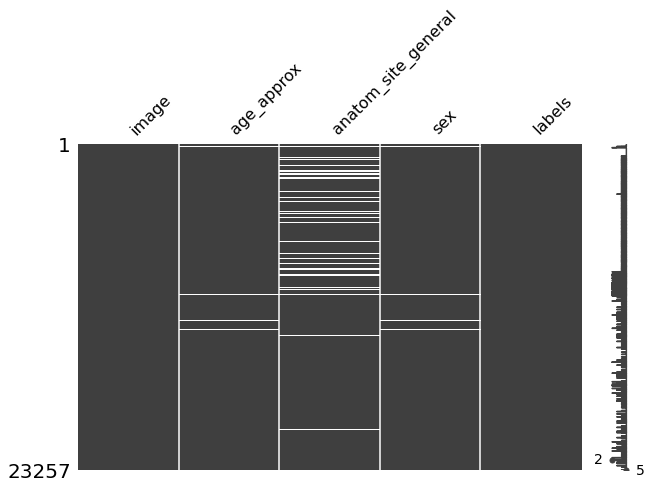

In [4]:
msno.matrix(df, figsize=(10,6))

<AxesSubplot:>

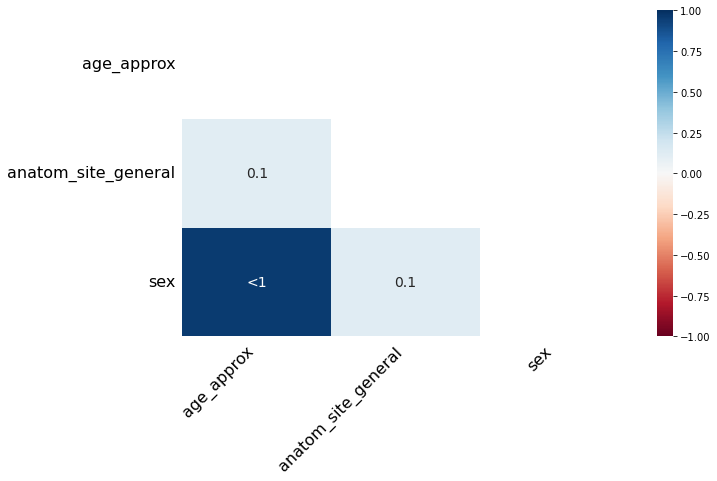

In [5]:
msno.heatmap(df, figsize=(10,6))

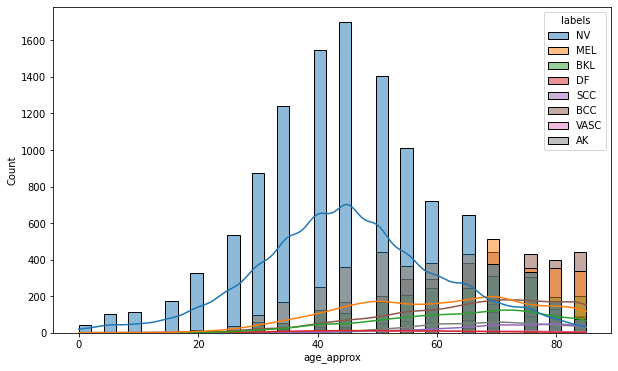

In [6]:
plt.figure(figsize=(10,6))
sns.histplot(x="age_approx", hue="labels", data=df, kde=True)
plt.show()

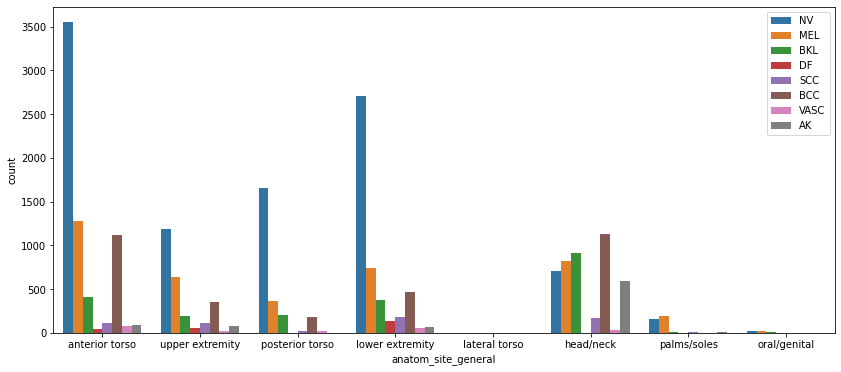

In [7]:
plt.figure(figsize=(14,6))
sns.countplot(x="anatom_site_general", hue="labels", data=df)
plt.legend(loc="upper right")
plt.show()

In [8]:
import plotly.express as px

fig = px.histogram(df, x="labels", nbins=8, width=800, height=400)
fig.show()

In [9]:
df["age_approx"] = df["age_approx"].fillna(df["age_approx"].mean()).astype("int")
df["anatom_site_general"] = df["anatom_site_general"].fillna("unknown")
df["sex"] = df["sex"].fillna("unknown")

df["age_bins"] = pd.cut(df["age_approx"], bins=[-1, 20, 40, 60, 80, 95], labels=False)

In [10]:
labels = {"NV": 0, "MEL": 1, "BCC": 1, "BKL": 0, "AK": 0, "SCC": 1, "VASC": 0, "DF": 0}

In [11]:
from sklearn.preprocessing import StandardScaler

X = df[["age_approx", "anatom_site_general", "sex", "labels"]]
X = pd.get_dummies(X, columns=["anatom_site_general", "sex"], drop_first=True)
X["labels"] = X["labels"].map(labels)

In [12]:
X, y = X.drop("labels", axis=1), X["labels"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=seed)

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

transformer = ColumnTransformer(transformers=[("scaler", StandardScaler(), ["age_approx",]),], remainder="passthrough")

pipe = make_pipeline(transformer, 
                     RandomForestClassifier(n_estimators=100, max_depth=15)
                    ).fit(x_train, y_train)

In [14]:
y_pred = pipe.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.84      0.80      4548
           1       0.62      0.48      0.54      2430

    accuracy                           0.72      6978
   macro avg       0.69      0.66      0.67      6978
weighted avg       0.71      0.72      0.71      6978



#### EfficientNet Model

<table>
    <tr>
        <td>
            <img src=https://miro.medium.com/max/1400/1*rnhgFRXetwD8PvxhZIpwIA.png width=800>
            </td><td>
        <img src=https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-06_at_10.45.54_PM.png width=800>
        </td></tr>
    </table>

In [15]:
# as EfficientNet (https://arxiv.org/pdf/1905.11946.pdf) has scalable architecture, define possible structures:
# here: (width, depth, image_size, dropout_rate)

params = {
    'efficientnet_b0': (1.0, 1.0, 224, 0.2),
    'efficientnet_b1': (1.0, 1.1, 240, 0.2),
    'efficientnet_b2': (1.1, 1.2, 260, 0.3),
    'efficientnet_b3': (1.2, 1.4, 300, 0.3),
    'efficientnet_b4': (1.4, 1.8, 380, 0.4),
    'efficientnet_b5': (1.6, 2.2, 456, 0.4),
    'efficientnet_b6': (1.8, 2.6, 528, 0.5),
    'efficientnet_b7': (2.0, 3.1, 600, 0.5),
}

In [16]:
# efficientnet_b0 params
width, depth, image_size, dropout = params["efficientnet_b0"]

In [17]:
# activation function: Swish

class Swish(nn.Module):
    """ 
    activation function: 
    Swish allows a small number of negative weights to be propagated through, 
    while ReLU (max(0, x)) thresholds all negative weights to zero.
    """
    def __init__(self, *args, **kwargs):
        super(Swish, self).__init__(*args, **kwargs)
    
    def forward(self, x):
        return x * torch.sigmoid(x)
    
    
class ConvBNBlock(nn.Module):
    """ 
    basic block: zero-padded 2D convolution, followed by batch 
    normalization and Swish activation
    """
    def __init__(self, in_channels, out_channels, kernel_size, *args, stride=1, groups=1, **kwargs):
        super(ConvBNBlock, self).__init__(*args, **kwargs)
        padding = self._get_padding(kernel_size, stride)
        self.block = nn.Sequential(
                nn.ZeroPad2d(padding),
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=0, groups=groups, bias=False),
                nn.BatchNorm2d(out_channels),
                Swish(),
            )
        
    def forward(self, x):
        return self.block(x)
        
    def _get_padding(self, kernel_size, stride):
        """ add corresponding padding """
        p = np.maximum(kernel_size - stride, 0)
        return [p // 2, p - p // 2, p // 2, p - p // 2]
    
    
class SqueezeExcitationBlock(nn.Module):
    """ 
    The Squeeze-and-Excitation Block is an architectural unit designed to improve 
    the representational power of a network by enabling it to perform 
    dynamic channel-wise feature recalibration
    """
    def __init__(self, in_channels, reduced_dim, *args, **kwargs):
        super(SqueezeExcitationBlock, self).__init__(*args, **kwargs)
        self.squeeze_excitation = nn.Sequential(
                    nn.AdaptiveAvgPool2d(1),
                    nn.Conv2d(in_channels, reduced_dim, kernel_size=1),
                    Swish(),
                    nn.Conv2d(reduced_dim, in_channels, kernel_size=1),
                    nn.Sigmoid()
            )
    
    def forward(self, x):
        return x * self.squeeze_excitation(x)  # which is similar to swish activation
    

class MBConvBlock(nn.Module):
    """
    Inverted Linear BottleNeck layer with Depth-Wise Separable Convolution
    implements inverted residual connection like MobileNetV2
    """
    def __init__(self, in_channels, out_channels, expand_ratio, kernel_size, stride, 
                 *args, reduction_ratio=0.4, drop_connect_rate=0.2, **kwargs):
        super(MBConvBlock, self).__init__(*args, **kwargs)
        
        self.drop_connect_rate = drop_connect_rate
        self.use_residual = (in_channels == out_channels) & (stride == 1)
        
        assert stride in (1, 2), "stride should be 1 or 2"
        assert kernel_size in (3, 5), "kernel_size should be 3 or 5"

        hidden_dim = in_channels * expand_ratio
        reduced_dim = np.maximum(1, int(in_channels / reduction_ratio))
        
        layers = []
        if in_channels != hidden_dim:
            layers.append(ConvBNBlock(in_channels, hidden_dim, kernel_size=1))

        layers.extend([
            ConvBNBlock(hidden_dim, hidden_dim, kernel_size, stride=stride, groups=hidden_dim),
            SqueezeExcitationBlock(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
        ])
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.use_residual:
            residual = x
            x = self.conv(x)
            return residual + self._drop_connections(x)
        else:
            return self.conv(x)
    
    def _drop_connections(self, x):
        """ 
        dropout probability mask, works similarily as Dropout, except we 
        disable individual weights (i.e., set them to zero), instead of nodes
        """
        if not self.training:
            return x  # identity
        keep_probability = 1.0 - self.drop_connect_rate
        batch_size = x.size(0)
        random_tensor = keep_probability + torch.rand(batch_size, 1, 1, 1, device=x.device)
        binary_tensor = random_tensor.floor()
        return x.div(keep_probability) * binary_tensor

In [18]:
# helper functions

def make_divisable(value, divisor=8):
    """ transform input value into closest divisable by divisor value """
    divisable_value = np.maximum(divisor, (value + divisor // 2) // divisor * divisor)
    if divisable_value < 0.9 * value:
        divisable_value += divisor
    return divisable_value

def round_filters(filters, width):
    """ return divisable number of filters """
    if width == 1.0:
        return filters
    return int(make_divisable(filters * width))  # int floor

def round_repeats(repeats, depth):
    """ calibrate number of net blocks """
    if depth == 1.0:
        return repeats
    return int(np.ceil(depth * repeats))

In [19]:
# final model

class EfficientNet(nn.Module):
    """ Gather all blocks (it is possible to upload pretrained weights from torch hub) """
    def __init__(self, *args, width=1.0, depth=1.0, dropout=0.2, num_classes=10, **kwargs):
        super(EfficientNet, self).__init__(*args, **kwargs)
        settings = [
           # t,  c,  n, s, k  -> expand_ratio, channels, repeats, init stride, kernel_size
            [1,  16, 1, 1, 3],  # MBConv1_3x3, SE, 112 -> 112
            [6,  24, 2, 2, 3],  # MBConv6_3x3, SE, 112 ->  56
            [6,  40, 2, 2, 5],  # MBConv6_5x5, SE,  56 ->  28
            [6,  80, 3, 2, 3],  # MBConv6_3x3, SE,  28 ->  14
            [6, 112, 3, 1, 5],  # MBConv6_5x5, SE,  14 ->  14
            [6, 192, 4, 2, 5],  # MBConv6_5x5, SE,  14 ->   7
            [6, 320, 1, 1, 3]   # MBConv6_3x3, SE,   7 ->   7
        ]
        out_channels = round_filters(32, width)
        layers = [ConvBNBlock(3, out_channels, kernel_size=3, stride=2),]
        
        in_channels = out_channels
        for expand, channel, repeat, strid, kernel in settings:
            out_channels = round_filters(channel, width)
            repeats = round_repeats(repeat, depth)
            for i in range(repeats):
                stride = strid if i == 0 else 1  # reduce spatial dims only on first step
                layers.extend([
                    MBConvBlock(in_channels, out_channels, expand_ratio=expand, kernel_size=kernel, stride=stride)
                ])
                in_channels = out_channels
                
        last_channels = round_filters(1280, width)
        layers.append(ConvBNBlock(in_channels, last_channels, kernel_size=1))
        
        self.features = nn.Sequential(*layers)  # name as in torch hub
        self.classifier = nn.Sequential(
                        nn.Dropout(p=dropout),
                        nn.Linear(last_channels, num_classes)
                )
        
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                fan_out = m.weight.size(0)
                init_range = 1.0 / np.sqrt(fan_out)
                nn.init.uniform_(m.weight, -init_range, init_range)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
                    
    def forward(self, x):
        x = self.features(x)
        x = x.mean(dim=[2, 3])  # flatten by mean of spatial dims
        x = self.classifier(x)
        return x

#### Dataset

In [20]:
directory = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/"

data = pd.read_csv("/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv").drop("UNK", axis=1)
data["labels"] = data.iloc[:, 1:].idxmax(axis=1)
data = data[~data["image"].str.contains("downsampled")]

classes_to_int = {v: i for i, v in enumerate(data.columns[1:-1])}
int_to_classes = {i: v for i, v in enumerate(data.columns[1:-1])}

data["labels"] = data["labels"].map(classes_to_int)

num_classes = len(classes_to_int)

data.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,labels
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [21]:
data["labels"].value_counts(normalize=True)

# class weights
# random_weighted_sampler for batch composing in dataloader
# focal loss

1    0.497012
0    0.178355
2    0.142882
4    0.096315
3    0.037279
7    0.027003
6    0.010878
5    0.010276
Name: labels, dtype: float64

In [22]:
# assign higher weight for minority classes in cross-entropy loss: loss gets higher when model make mistakes on minor class
class_weights = compute_class_weight("balanced", classes=np.unique(data["labels"]), y=data["labels"])
# class_weights = class_weights / class_weights.sum()  # weights normalization, unneccessary

In [23]:
# augmentations
# train: different random flips, rotations, and color shifts
train_transforms = A.Compose([
                      A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, 
                                                    sat_shift_limit=0.2, 
                                                    val_shift_limit=0.2, 
                                                    p=0.2),      
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                                 contrast_limit=0.2, 
                                                 p=0.5)],p=0.2),
                      A.OneOf(
                              [A.HorizontalFlip(p=0.5),
                               A.VerticalFlip(p=0.5),
                               A.RandomRotate90(p=0.5),
                               A.Transpose(p=0.5),
                              ], p=0.5),
                      A.Resize(height=image_size, width=image_size, p=1),
                      A.Cutout(num_holes=6, max_h_size=10, max_w_size=10, fill_value=0, p=0.1),
                      A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

# only resize, scale [-1, 1] and converting to tensor array[h,w,c] -> tensor[c,h,w]
valid_transforms = A.Compose([
                      A.Resize(height=image_size, width=image_size, p=1),
                      A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

# inverse trasformations of a single image-tensor
def inverse_transforms(tensor):
    tensor = tensor 
    if tensor.size(0) == 1 and len(tensor.shape) == 4:
        tensor.squeeze_(0)
    tensor = torch.clamp(tensor * 0.5 + 0.5, min=0., max=1.)
    tensor = tensor.cpu().detach().numpy().transpose(1,2,0)

    return tensor

In [24]:
x_train, x_test = train_test_split(data, test_size=1600, stratify=data["labels"], random_state=seed)
x_valid, x_test = train_test_split(x_test, test_size=400, stratify=x_test["labels"], random_state=seed)

x_train.reset_index(drop=True, inplace=True)
x_valid.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)

print(f"train size: {len(x_train)}, valid size: {len(x_valid)}, test size: {len(x_test)}")

train size: 21657, valid size: 1200, test size: 400


In [25]:
# define dataset and dataloder

class ISICDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):
        row = self.data.loc[ix].squeeze()
        image = Image.open(directory + row["image"] + ".jpg")
        image = np.array(image)
        
        sample = {"image": image}
        image = self.transforms(**sample)["image"]
        
        label = torch.as_tensor(row["labels"], dtype=torch.int64)
        
        return image, label
    
    def collate_fn(self, batch):
        images, labels = list(zip(*batch))
        images, labels = [[tensor[None] for tensor in subset] for subset in (images, labels)]
        images, labels = [torch.cat(subset, dim=0).to(device) for subset in (images, labels)]
        return images, labels

In [26]:
batch_size = 128

train_ds = ISICDataset(x_train, train_transforms)
valid_ds = ISICDataset(x_valid, valid_transforms)
test_ds = ISICDataset(x_test, valid_transforms)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, collate_fn=valid_ds.collate_fn)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=test_ds.collate_fn)

#### Objectives and metrics

In [27]:
class FocalLoss(nn.Module):
    """ 
    https://github.com/AdeelH/pytorch-multi-class-focal-loss/blob/master/focal_loss.py
    
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """
    def __init__(self, *args, 
                 alpha: torch.Tensor = None, 
                 gamma: float = 2.0, 
                 reduction: str = 'mean',
                 ignore_index: int = -100,
                 **kwargs
                 ):
        """
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 2.0
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(
                'Reduction must be one of: "mean", "sum", "none".')

        super(FocalLoss, self).__init__(*args, **kwargs)
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        if x.ndim > 2:
            c = x.shape[1]  # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            y = y.view(-1)  # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
        
        y = y.long()
        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return torch.tensor(0.)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt) (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss
        
def calc_accuracy(y_pred, y_true):
    return (y_true == torch.max(y_pred, 1)[1]).float().mean()

#### Training and evaluation functions

In [28]:
def train_one_batch(data, model, criterion, optimizer):
    model.train()
    images, labels = data
    
    optimizer.zero_grad()
    out = model(images)
    loss = criterion(out, labels)
    
    loss.backward()
    optimizer.step()
    
    accuracy = calc_accuracy(out, labels).item()
    
    return loss.item(), accuracy

@torch.no_grad()
def validate_one_batch(data, model, criterion):
    model.eval()
    images, labels = data
    
    out = model(images)
    loss = criterion(out, labels)
    
    accuracy = calc_accuracy(out, labels)
    
    return loss.item(), accuracy.item()

In [29]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, path='model.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None, **kwargs):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = {'model': EfficientNet(**kwargs),
                          'state_dict': model.state_dict(),
                          }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [30]:
# inverse normalized frequency of classes
weights = np.bincount(x_train["labels"])
weights[weights == 0] = 1 
weights = 1 / weights
weights /= weights.sum()

#### Define model, loss function, optimizer, etc.

In [31]:
params = {"width": width, 
          "depth": depth, 
          "dropout": dropout, 
          "num_classes": num_classes
         }

model = EfficientNet(**params).to(device)

# criterion = FocalLoss(gamma=2.0, alpha=torch.as_tensor(weights, dtype=torch.float32).to(device))  # for binary rule of thumb: alpha=0.25
# criterion = FocalLoss(gamma=2.0, alpha=torch.as_tensor(class_weights, dtype=torch.float32).to(device))
# criterion = FocalLoss(gamma=2.0, alpha=None)  # not weighted

# weights are prety high, maybe it is hard for model to keep track for all classes, but (despite lower overall accuracy) weighted version captures more minor classes correctly
# criterion = nn.CrossEntropyLoss(weight=torch.as_tensor(class_weights, dtype=torch.float32).to(device))
criterion = nn.CrossEntropyLoss()  # not weighted

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, min_lr=1e-7)
stopper = EarlyStopping(patience=5)

In [32]:
print(f" Number of training parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

 Number of training parameters: 9666016


#### Train

In [33]:
import time

EPOCHS = 40  # 100 (decrease to save GPU limits...)
print_freq = 20

for epoch in range(1, EPOCHS+1):

    train_loss, train_accs = [], []
    for step, batch in enumerate(train_dl, 1):
        time_1 = time.time()
        
        loss, accuracy = train_one_batch(batch, model, criterion, optimizer)

        train_loss.append(loss)
        train_accs.append(accuracy)
        
        if step % print_freq == 0:
            print('epoch:', epoch, 
                  '\tstep:', step, '/', len(train_dl),
                  '\ttrain loss:', '{:.4f}'.format(loss),
                  '\ttrain accuracy:','{:.4f}'.format(accuracy),
                  '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')
    
    valid_loss, valid_accs = [], []
    for step, batch in enumerate(tqdm(valid_dl)):
        loss, accuracy = validate_one_batch(batch, model, criterion)
        
        valid_loss.append(loss)
        valid_accs.append(accuracy)
        
    print('epoch:', epoch, '/', EPOCHS,
          '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
          '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
          '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
          '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))
        
    stopper(np.mean(valid_loss), model, **params)
    scheduler.step(np.mean(valid_loss))
    
test_loss, test_accs = [], []
for step, batch in enumerate(tqdm(test_dl)):
    loss, accuracy = validate_one_batch(batch, model, criterion)

    test_loss.append(loss)
    test_accs.append(accuracy)

print('\ttest loss:', '{:.4f}'.format(np.mean(test_loss)),
      '\ttest accuracy', '{:.4f}'.format(np.mean(test_accs)))

epoch: 1 	step: 20 / 170 	train loss: 0.0952 	train accuracy: 0.3906 	time: 10.3151 s
epoch: 1 	step: 40 / 170 	train loss: 0.0769 	train accuracy: 0.0781 	time: 10.3169 s
epoch: 1 	step: 60 / 170 	train loss: 0.0586 	train accuracy: 0.0938 	time: 10.3935 s
epoch: 1 	step: 80 / 170 	train loss: 0.1961 	train accuracy: 0.2656 	time: 10.3144 s
epoch: 1 	step: 100 / 170 	train loss: 0.0629 	train accuracy: 0.0547 	time: 10.3099 s
epoch: 1 	step: 120 / 170 	train loss: 0.0539 	train accuracy: 0.1953 	time: 10.3085 s
epoch: 1 	step: 140 / 170 	train loss: 0.0436 	train accuracy: 0.1953 	time: 10.3165 s
epoch: 1 	step: 160 / 170 	train loss: 0.0455 	train accuracy: 0.1641 	time: 10.3038 s


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 / 40 	train loss: 0.0715 	valid loss: 0.0459 	train accuracy 0.1441 	valid accuracy 0.1594
epoch: 2 	step: 20 / 170 	train loss: 0.0484 	train accuracy: 0.3125 	time: 10.3093 s
epoch: 2 	step: 40 / 170 	train loss: 0.0702 	train accuracy: 0.1328 	time: 10.4373 s
epoch: 2 	step: 60 / 170 	train loss: 0.0351 	train accuracy: 0.3359 	time: 10.2988 s
epoch: 2 	step: 80 / 170 	train loss: 0.0499 	train accuracy: 0.2812 	time: 10.3004 s
epoch: 2 	step: 100 / 170 	train loss: 0.0385 	train accuracy: 0.3672 	time: 10.3198 s
epoch: 2 	step: 120 / 170 	train loss: 0.0340 	train accuracy: 0.3594 	time: 10.3126 s
epoch: 2 	step: 140 / 170 	train loss: 0.0437 	train accuracy: 0.3984 	time: 10.3308 s
epoch: 2 	step: 160 / 170 	train loss: 0.0362 	train accuracy: 0.3203 	time: 10.3882 s


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 2 / 40 	train loss: 0.0445 	valid loss: 0.0411 	train accuracy 0.2845 	valid accuracy 0.3474
Model saved to: model.pth


KeyboardInterrupt: 

#### Load and check visually

In [34]:
def load_checkpoint(filepath="model.pth", device="cuda"):
    checkpoint = torch.load(filepath, map_location=device)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint()

In [35]:
@torch.no_grad()
def plot(num_images, model):
    model.eval()
    indices = np.random.choice(np.arange(len(test_ds)), size=num_images)
    num_cols = 3
    num_rows = int(np.ceil(num_images / num_cols))
    
    plt.figure(figsize=(num_rows * 3, num_cols*3))
    for j, i in enumerate(indices, 1):
        image, label = test_ds[i]
        out = model(image.unsqueeze(0).to(device))
        y_pred = int_to_classes.get(torch.max(out, 1)[1][0].item(), "error")
        label = int_to_classes.get(label.item(), "error")
        
        image = inverse_transforms(image)
        plt.subplot(num_rows, num_cols, j)
        plt.imshow(image)
        plt.title(f"True label: {label}, pred: {y_pred}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
plot(num_images=12, model=model)

# [Results](https://www.kaggle.com/code/pankratozzi/pytorch-efficientnet-classification)